## Satellite image segmentation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import mxnet as mx
import mxnet.ndarray as nd
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn

from mxnet.gluon.data import Dataset, DataLoader
from mxnet.gluon.loss import Loss
from mxnet import image

### Data preparation

In [3]:
from skimage.io import imsave, imread
from datetime import datetime
import collections

In [4]:
geopedia_layers = {'tulip_field_2016':'ttl1904', 'tulip_field_2017':'ttl1905'}

In [5]:
class ImageWithMaskDataset(Dataset):
    """
    A dataset for loading images (with masks).
    Based on: mxnet.incubator.apache.org/tutorials/python/data_augmentation_with_masks.html
    
    Parameters
    ----------
    root : str
        Path to root directory.
    imgdir: str
        Path to folder containing the images, relative to root
    maskdir: str 
        Path to folder containing the masks/ground truth, relative to root
    transform : callable, default None
        A function that takes data and label and transforms them:
    ::
        transform = lambda data, label: (data.astype(np.float32)/255, label)
    """
    def __init__(self, imgdir, maskdir, transform=None):
        self._imgdir = os.path.expanduser(imgdir)
        self._maskdir = os.path.expanduser(maskdir)
        self._transform = transform
        self.imgdir = imgdir
        self._exts = ['.png']
        self._list_images(self._imgdir)

    def _list_images(self, root):
        images = collections.defaultdict(dict)
        for filename in sorted(os.listdir(root)):
            name, ext = os.path.splitext(filename)
            mask_flag = "geopedia" in name
            if ext.lower() not in self._exts:
                continue
            if not mask_flag:
                patch_id = filename.split('_')[1]
                year = datetime.strptime(filename.split('_')[3], "%Y%m%d-%H%M%S").year
                mask_fn = 'tulip_{}_geopedia_{}.png'.format(patch_id, geopedia_layers['tulip_field_{}'.format(year)])
                images[name]["base"] = filename
                images[name]["mask"] = mask_fn
        self._image_list = list(images.values())

    def __getitem__(self, idx):
        assert 'base' in self._image_list[idx], "Couldn't find base image for: " + image_list[idx]["mask"]
        base_filepath = os.path.join(self._imgdir, self._image_list[idx]["base"])
        base = mx.image.imread(base_filepath)
        assert 'mask' in self._image_list[idx], "Couldn't find mask image for: " + image_list[idx]["base"]
        mask_filepath = os.path.join(self._maskdir, self._image_list[idx]["mask"])
        mask = mx.image.imread(mask_filepath, flag=0)
        if self._transform is not None:
            return self._transform(base, mask)
        else:
            return base, mask

    def __len__(self):
        return len(self._image_list)

Image transformations for data augmentation. At the moment, data augmentation will happen offline before the training, so we will only use the transforms to reorder the channels, change data type, etc. Leaving the rest of them here in case this design choice changes in the future.

In [6]:
def positional_augmentation(joint):
    # Random crop
    crop_height = img_height
    crop_width  = img_width
    aug = mx.image.RandomCropAug(size=(crop_width, crop_height)) # Watch out: weight before height in size param!
    aug_joint = aug(joint)
    return aug_joint

def joint_transform(base, mask):
    ### Convert types
    base = base.astype('float32')/255
    mask = mask.astype('float32')/255
    
    ### Join
    # Concatenate on channels dim, to obtain an 6 channel image
    # (3 channels for the base image, plus 3 channels for the mask)
    base_channels = base.shape[2] # so we know where to split later on
    joint = mx.nd.concat(base, mask, dim=2)

    ### Augmentation Part 1: positional
    aug_joint = positional_augmentation(joint)
    
    ### Split
    aug_base = aug_joint[:, :, :base_channels]
    aug_mask = aug_joint[:, :, base_channels:]
    
    # Convert mask to binary
    aug_mask = (aug_mask > 0.4).astype('float32')
    
    # Reshape the tensors so the order is now (channels, w, h)
    aug_base =  mx.nd.transpose(aug_base, (2,0,1))
    aug_mask =  mx.nd.transpose(aug_mask, (2,0,1))
    
    return aug_base, aug_mask

###  U-Net

In [7]:
def conv_block(channels, kernel_size):
    out = nn.HybridSequential()
    out.add(
        nn.Conv2D(channels, kernel_size, padding=1, use_bias=False),
        nn.BatchNorm(),
        nn.Activation('relu')
    )
    return out

In [8]:
def down_block(channels):
    out = nn.HybridSequential()
    out.add(
        conv_block(channels, 3),
        conv_block(channels, 3)
    )
    return out

In [9]:
class up_block(nn.HybridBlock):
    def __init__(self, channels, shrink=True, **kwargs):
        super(up_block, self).__init__(**kwargs)
        self.upsampler = nn.Conv2DTranspose(channels=channels, kernel_size=4, strides=2, 
                                            padding=1, use_bias=False)
        self.conv1 = conv_block(channels, 1)
        self.conv3_0 = conv_block(channels, 3)
        if shrink:
            self.conv3_1 = conv_block(int(channels/2), 3)
        else:
            self.conv3_1 = conv_block(channels, 3)
    def hybrid_forward(self, F, x, s):
        x = self.upsampler(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.Crop(*[x,s], center_crop=True)
        x = s + x
        x = self.conv3_0(x)
        x = self.conv3_1(x)
        return x

In [10]:
class Unet(nn.HybridBlock):
    def __init__(self, **kwargs):
        super(Unet, self).__init__(**kwargs)
        with self.name_scope():
            self.d0 = down_block(64)
            
            self.d1 = nn.HybridSequential()
            self.d1.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(128))
            
            self.d2 = nn.HybridSequential()
            self.d2.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(256))
            
            self.d3 = nn.HybridSequential()
            self.d3.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(512))
            
            self.d4 = nn.HybridSequential()
            self.d4.add(nn.MaxPool2D(2,2,ceil_mode=True), down_block(1024))
            
            self.u3 = up_block(512, shrink=True)
            self.u2 = up_block(256, shrink=True)
            self.u1 = up_block(128, shrink=True)
            self.u0 = up_block(64, shrink=False)
            
            self.conv = nn.Conv2D(2,1)
            
    def hybrid_forward(self, F, x):
        x0 = self.d0(x)
        x1 = self.d1(x0)
        x2 = self.d2(x1)
        x3 = self.d3(x2)
        x4 = self.d4(x3)

        y3 = self.u3(x4,x3)
        y2 = self.u2(y3,x2)
        y1 = self.u1(y2,x1)
        y0 = self.u0(y1,x0)
        
        out = F.softmax(self.conv(y0), axis=1)
        
        return out

### Loss

The IoU metric tends to have a "squaring" effect on the errors relative to the Dice score (aka F score). So the F score tends to measure something closer to average performance, while the IoU score measures something closer to the worst case performance.

https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou

As we are not very confident on the quality of the training data/ground truth, lets go for the Dice coeff

In [11]:
class DiceCoeffLoss(Loss):
    """
    Soft dice coefficient loss.
    Based on https://github.com/Lasagne/Recipes/issues/99
    Input:
       pred: (batch size, c, w, h) network output, must sum to 1 over c channel (such as after softmax)
       label:(batch size, c, w, h) one hot encoding of ground truth
       eps; smoothing factor to avoid division by zero
    :param eps: 
    Output:
        Loss tensor with shape (batch size) 
    """

    def __init__(self, eps=1e-7, _weight = None, _batch_axis= 0, **kwards):
        Loss.__init__(self, weight=_weight, batch_axis=_batch_axis, **kwards)
        self.eps = eps

    def hybrid_forward(self, F, label, pred):  
        # One-hot encode the label
        label = nd.concatenate([label != 1, label], axis=1)
        
        axes = tuple(range(2, len(pred.shape)))
        intersect = nd.sum(pred * label, axis=axes)
        denom = nd.sum(pred + label, axis=axes)
        return - (2. *intersect / (denom + self.eps)).mean(axis=1)

### Evaluation metric

In [12]:
class DiceCoeffMetric(mx.metric.EvalMetric):
    """Stores a moving average of the dice coeff"""
    def __init__(self, axis=[2,3], smooth=1):
        super(DiceCoeffMetric, self).__init__('DiceCoeff')
        self.name = 'Dice coefficient'
        self.axis = axis
        self.smooth = smooth
        self.reset()

    def reset(self):
        """
        override reset behavior
        """
        self.num_inst = 0
        self.sum_metric = 0.0

    def update(self, label, pred):
        """
        Implementation of updating metrics
        """
        intersect = nd.sum((label * pred), axis=self.axis)
        dice = (2. * intersect + self.smooth)/(nd.sum(label, axis=self.axis) + nd.sum(pred, axis=self.axis) + self.smooth)
        self.sum_metric += nd.sum(dice, axis=0)
        self.num_inst += pred.shape[0]

        
    def get(self):
        """Get the current evaluation result.
        Override the default behavior

        Returns
        -------
        name : str
           Name of the metric.
        value : float
           Value of the evaluation.
        """
        value = (self.sum_metric / self.num_inst).asscalar() if self.num_inst != 0 else float('nan')
        return (self.name, value)


In [13]:
class IouMetric(mx.metric.EvalMetric):
    """Stores a moving average of the intersection over union metric"""
    def __init__(self, axis=[2,3], smooth=1e-7):
        super(IouMetric, self).__init__('IoU')
        self.name = 'IoU'
        self.axis = axis
        self.smooth = smooth
        self.reset()

    def reset(self):
        """
        override reset behavior
        """
        self.num_inst = 0
        self.sum_metric = 0.0

    def update(self, label, pred):
        """
        Implementation of updating metrics
        """
        i = nd.sum((pred==1)*(label==1), axis=self.axis)
        u = nd.sum(pred, axis=self.axis) + nd.sum(label, axis=self.axis) - i
        iou = (i + self.smooth) / (u + self.smooth)
        self.sum_metric += nd.sum(iou, axis=0)
        self.num_inst += pred.shape[0]
        
    def get(self):
        """Get the current evaluation result.
        Override the default behavior

        Returns
        -------
        name : str
           Name of the metric.
        value : float
           Value of the evaluation.
        """
        value = (self.sum_metric / self.num_inst).asscalar() if self.num_inst != 0 else float('nan')
        return (self.name, value)

In [14]:
def metric_str(names, vals):
    return '{}={}'.format(names, vals)

### Training

In [15]:
def evaluate(data_iterator, net):
    metric = IouMetric()
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        # data = color_normalize(data/255, mean, std)
        output = net(data)
        pred = nd.reshape(np.argmax(output, axis=1), (0, 1, img_width, img_height))
        # prediction = mx.nd.argmax(output, axis=1)
        metric.update(label, pred)
    return metric.get()[1]

In [16]:
def train_util(net, train_iter, val_iter, loss_fn,
               trainer, ctx, epochs, batch_size, checkpoint_dir, init_epoch=0):
    '''
    Function to train the neural network.
    
    PARAMS:
    - net: network to train
    - train_iter: gluon.data.DataLoader with the training data
    - validation_iter: "                      "  validation data
    - loss_fn: loss function to use for training
    - trainer: gluon.Trainer to use for training
    - ctx: context where we will operate (GPU or CPU)
    - epochs: number of epochs to train for
    - batch_size
    - checkpoint_dir: directory where checkpoints are saved every 100 batches
    - init_epoch: set to the initial epoch in case training is resumed from a previous execution
    '''
    os.makedirs(checkpoint_dir, exist_ok=True)
    res = {'train':[],'val':[]}
    for epoch in range(1 + init_epoch, epochs + init_epoch+1):
        metric = IouMetric()
        for i, (data, label) in enumerate(train_iter):
            st = time.time()
            # Ensure context            
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # Normalize images?
            # data = color_normalize(data/255, mean, std)
            
            with mx.autograd.record():
                output = net(data)
                loss = loss_fn(label, output)
                pred = nd.reshape(np.argmax(output, axis=1), (0, 1, img_width, img_height))
                
            loss.backward()
            trainer.step(data.shape[0], ignore_stale_grad=True)
            
            #  Keep a moving average of the losses
            metric.update(label, pred)
            names, vals = metric.get()
            if i%25 == 0:
                print('[Epoch %d Batch %d] speed: %f samples/s, training: %s'%(epoch, i, batch_size/(time.time()-st), metric_str(names, vals)))
            if i!=0 and i%500 == 0:
                # Every 500 batches, save params and evaluate performance on the val set
                names, train_acc = metric.get()
                metric.reset()
                val_acc = evaluate(val_iter, net)
                net.save_params('%s/%d-%d.params'%(checkpoint_dir, epoch, i))
                res['train'].append(train_acc)
                res['val'].append(val_acc)
                print("Epoch %s Batch %d| train IoU: %s | val IoU: %s " % (epoch, i, train_acc, val_acc))
                
        net.save_params('%s/%d-%d.params'%(checkpoint_dir, epoch, 0))
        names, train_acc = metric.get()
        val_acc = evaluate(val_iter, net)
        res['train'].append(train_acc)
        res['val'].append(val_acc)
        print("Epoch %s | train IoU %s | val IoU %s " % (epoch, train_acc, val_acc))
        metric.reset()
        
    return res

### Run

In [17]:
ctx = mx.gpu(0)

In [18]:
batch_size = 8
img_width  = 256
img_height = 256

Training images can be found in the output folder of our Augmentor, train/, along with their corresponding masks. Validation images are in val/ but their masks are in masks/ . See prepare_data.ipynb for reference.

In [19]:
train_dir = '../data/tulips/bloom/train/'
val_dir   = '../data/tulips/bloom/val/'
mask_dir  = '../data/tulips/bloom/masks/'

Create train and validation DataLoaders from our Datasets. No transformations are applied because data augmentation takes place in a previous offline step.

In [20]:
train_ds = ImageWithMaskDataset(train_dir, train_dir, transform=joint_transform)
train_iter = gluon.data.DataLoader(train_ds, batch_size)

In [21]:
val_ds  = ImageWithMaskDataset(val_dir, mask_dir, transform=joint_transform)
val_iter= gluon.data.DataLoader(val_ds, batch_size)

The two cells below are only used to visually check if our ImageWithMaskDataset's are working.

In [22]:
def plot_mx_arrays(arrays):
    """
    Array expected to be height x width x 3 (channels), and values are floats between 0 and 255.
    """
    plt.subplots(figsize=(14, 8))
    for idx, array in enumerate(arrays):
        array = mx.nd.transpose(array, (1, 2, 0))
        if array.shape[2] != 3:
            array = nd.reshape(array, (array.shape[0],array.shape[0]))
        plt.subplot(1, 2, idx+1)
        plt.imshow(array.asnumpy())

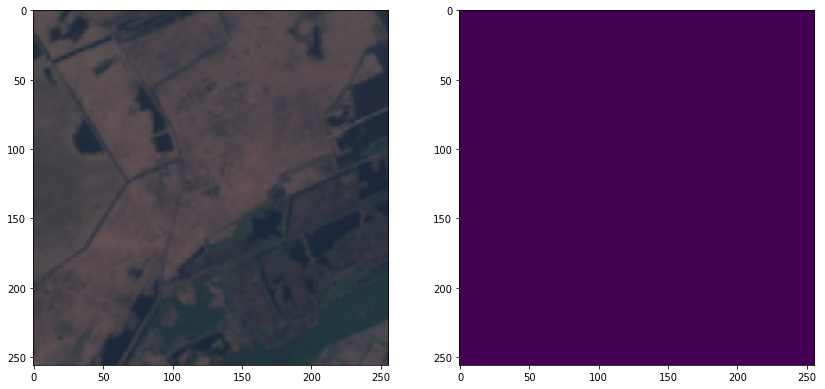

In [23]:
sample = val_ds.__getitem__(222)
sample_base = sample[0].astype('float32')
sample_mask = sample[1].astype('float32')

plot_mx_arrays([sample_base, sample_mask])

Instantiate a U-Net and train it

In [24]:
net = Unet()

In [25]:
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
net.hybridize()

In [26]:
loss = DiceCoeffLoss()
trainer = gluon.Trainer(net.collect_params(), 'adam', 
            {'learning_rate': 1e-4, 'beta1':0.9, 'beta2':0.99})

In [27]:
epochs = 50
checkpoint_dir = 'checkpoints/unet1'

In [ ]:
results = train_util(net, train_iter, val_iter, loss, trainer, ctx,
           epochs, batch_size, checkpoint_dir, init_epoch = 0)

[Epoch 1 Batch 0] speed: 1.164721 samples/s, training: IoU=0.03570305556058884
[Epoch 1 Batch 25] speed: 34.629862 samples/s, training: IoU=0.06868740171194077
[Epoch 1 Batch 50] speed: 33.906689 samples/s, training: IoU=0.07382932305335999
[Epoch 1 Batch 75] speed: 34.079149 samples/s, training: IoU=0.09699449688196182
[Epoch 1 Batch 100] speed: 33.953384 samples/s, training: IoU=0.11370440572500229
[Epoch 1 Batch 125] speed: 32.763169 samples/s, training: IoU=0.12751542031764984
[Epoch 1 Batch 150] speed: 33.977279 samples/s, training: IoU=0.1402452290058136
[Epoch 1 Batch 175] speed: 33.136645 samples/s, training: IoU=0.1427796483039856
[Epoch 1 Batch 200] speed: 34.563656 samples/s, training: IoU=0.14904433488845825
[Epoch 1 Batch 225] speed: 34.440023 samples/s, training: IoU=0.1538364440202713
[Epoch 1 Batch 250] speed: 32.550130 samples/s, training: IoU=0.158589169383049
[Epoch 1 Batch 275] speed: 33.679180 samples/s, training: IoU=0.16713939607143402
[Epoch 1 Batch 300] speed: 

[Epoch 1 Batch 2425] speed: 34.189990 samples/s, training: IoU=0.2957010865211487
[Epoch 1 Batch 2450] speed: 33.944179 samples/s, training: IoU=0.2944793701171875
[Epoch 1 Batch 2475] speed: 33.565643 samples/s, training: IoU=0.2959842085838318
Epoch 1 | train IoU 0.29670054 | val IoU 0.4322299 
[Epoch 2 Batch 0] speed: 34.015892 samples/s, training: IoU=0.2683814465999603
[Epoch 2 Batch 25] speed: 32.773217 samples/s, training: IoU=0.43570759892463684
[Epoch 2 Batch 50] speed: 33.514516 samples/s, training: IoU=0.32610881328582764
[Epoch 2 Batch 75] speed: 34.008927 samples/s, training: IoU=0.2999902367591858
[Epoch 2 Batch 100] speed: 34.286693 samples/s, training: IoU=0.29326605796813965
[Epoch 2 Batch 125] speed: 34.517185 samples/s, training: IoU=0.31314703822135925
[Epoch 2 Batch 150] speed: 33.873213 samples/s, training: IoU=0.3142293393611908
[Epoch 2 Batch 175] speed: 34.560203 samples/s, training: IoU=0.30948254466056824
[Epoch 2 Batch 200] speed: 34.110848 samples/s, traini

[Epoch 2 Batch 2350] speed: 33.920159 samples/s, training: IoU=0.3295350968837738
[Epoch 2 Batch 2375] speed: 33.574510 samples/s, training: IoU=0.3273291289806366
[Epoch 2 Batch 2400] speed: 34.151468 samples/s, training: IoU=0.3256385326385498
[Epoch 2 Batch 2425] speed: 33.779199 samples/s, training: IoU=0.32230690121650696
[Epoch 2 Batch 2450] speed: 34.015823 samples/s, training: IoU=0.32471123337745667
[Epoch 2 Batch 2475] speed: 33.589600 samples/s, training: IoU=0.3280152678489685
Epoch 2 | train IoU 0.3295023 | val IoU 0.4122275 
[Epoch 3 Batch 0] speed: 33.833013 samples/s, training: IoU=0.261606901884079
[Epoch 3 Batch 25] speed: 34.184312 samples/s, training: IoU=0.4302528202533722
[Epoch 3 Batch 50] speed: 33.211523 samples/s, training: IoU=0.3458397090435028
[Epoch 3 Batch 75] speed: 34.169204 samples/s, training: IoU=0.33406341075897217
[Epoch 3 Batch 100] speed: 33.878001 samples/s, training: IoU=0.3235842287540436
[Epoch 3 Batch 125] speed: 33.897920 samples/s, trainin

[Epoch 3 Batch 2275] speed: 34.410285 samples/s, training: IoU=0.3837692141532898
[Epoch 3 Batch 2300] speed: 33.736440 samples/s, training: IoU=0.3767799735069275
[Epoch 3 Batch 2325] speed: 33.836186 samples/s, training: IoU=0.3698248863220215
[Epoch 3 Batch 2350] speed: 33.784368 samples/s, training: IoU=0.36440354585647583
[Epoch 3 Batch 2375] speed: 33.743938 samples/s, training: IoU=0.36185580492019653
[Epoch 3 Batch 2400] speed: 31.195375 samples/s, training: IoU=0.35826316475868225
[Epoch 3 Batch 2425] speed: 33.722132 samples/s, training: IoU=0.3567171096801758
[Epoch 3 Batch 2450] speed: 33.629897 samples/s, training: IoU=0.3599216043949127
[Epoch 3 Batch 2475] speed: 33.414559 samples/s, training: IoU=0.3611343502998352
Epoch 3 | train IoU 0.36490002 | val IoU 0.5539014 
[Epoch 4 Batch 0] speed: 33.616151 samples/s, training: IoU=0.41982370615005493
[Epoch 4 Batch 25] speed: 34.359052 samples/s, training: IoU=0.4828515648841858
[Epoch 4 Batch 50] speed: 34.120526 samples/s, 

[Epoch 4 Batch 2200] speed: 33.514784 samples/s, training: IoU=0.3698316514492035
[Epoch 4 Batch 2225] speed: 34.492490 samples/s, training: IoU=0.3721219599246979
[Epoch 4 Batch 2250] speed: 32.406653 samples/s, training: IoU=0.367544025182724
[Epoch 4 Batch 2275] speed: 32.392419 samples/s, training: IoU=0.37616950273513794
[Epoch 4 Batch 2300] speed: 34.460077 samples/s, training: IoU=0.37254613637924194
[Epoch 4 Batch 2325] speed: 34.328646 samples/s, training: IoU=0.3659845292568207
[Epoch 4 Batch 2350] speed: 33.277233 samples/s, training: IoU=0.36092689633369446
[Epoch 4 Batch 2375] speed: 34.459900 samples/s, training: IoU=0.3627057671546936
[Epoch 4 Batch 2400] speed: 34.306569 samples/s, training: IoU=0.36366403102874756
[Epoch 4 Batch 2425] speed: 33.774405 samples/s, training: IoU=0.3585193157196045
[Epoch 4 Batch 2450] speed: 34.309375 samples/s, training: IoU=0.3590412735939026
[Epoch 4 Batch 2475] speed: 33.613895 samples/s, training: IoU=0.35929998755455017
Epoch 4 | tr

[Epoch 5 Batch 2125] speed: 34.219069 samples/s, training: IoU=0.4261898994445801
[Epoch 5 Batch 2150] speed: 34.105058 samples/s, training: IoU=0.4250471591949463
[Epoch 5 Batch 2175] speed: 33.562218 samples/s, training: IoU=0.4365434944629669
[Epoch 5 Batch 2200] speed: 33.182850 samples/s, training: IoU=0.43030011653900146
[Epoch 5 Batch 2225] speed: 33.749402 samples/s, training: IoU=0.4249963164329529
[Epoch 5 Batch 2250] speed: 33.585599 samples/s, training: IoU=0.42082539200782776
[Epoch 5 Batch 2275] speed: 34.101869 samples/s, training: IoU=0.42255452275276184
[Epoch 5 Batch 2300] speed: 33.511035 samples/s, training: IoU=0.413247287273407
[Epoch 5 Batch 2325] speed: 34.498660 samples/s, training: IoU=0.4094778299331665
[Epoch 5 Batch 2350] speed: 32.938321 samples/s, training: IoU=0.40190190076828003
[Epoch 5 Batch 2375] speed: 33.402351 samples/s, training: IoU=0.4035632312297821
[Epoch 5 Batch 2400] speed: 33.466349 samples/s, training: IoU=0.40494513511657715
[Epoch 5 Bat

[Epoch 6 Batch 2050] speed: 32.915961 samples/s, training: IoU=0.4058590829372406
[Epoch 6 Batch 2075] speed: 33.508191 samples/s, training: IoU=0.415200412273407
[Epoch 6 Batch 2100] speed: 34.055871 samples/s, training: IoU=0.41308557987213135
[Epoch 6 Batch 2125] speed: 33.806629 samples/s, training: IoU=0.40742814540863037
[Epoch 6 Batch 2150] speed: 34.476577 samples/s, training: IoU=0.3912000358104706
[Epoch 6 Batch 2175] speed: 33.760642 samples/s, training: IoU=0.3993838131427765
[Epoch 6 Batch 2200] speed: 33.429772 samples/s, training: IoU=0.39796778559684753
[Epoch 6 Batch 2225] speed: 33.546347 samples/s, training: IoU=0.39771485328674316
[Epoch 6 Batch 2250] speed: 34.301554 samples/s, training: IoU=0.3987603485584259
[Epoch 6 Batch 2275] speed: 34.049477 samples/s, training: IoU=0.405291348695755
[Epoch 6 Batch 2300] speed: 34.046472 samples/s, training: IoU=0.39313220977783203
[Epoch 6 Batch 2325] speed: 34.136389 samples/s, training: IoU=0.3854764401912689
[Epoch 6 Batc

[Epoch 7 Batch 2000] speed: 33.332306 samples/s, training: IoU=0.4081764221191406
Epoch 7 Batch 2000| train IoU: 0.40817642 | val IoU: 0.51257765 
[Epoch 7 Batch 2025] speed: 34.250750 samples/s, training: IoU=0.38538146018981934
[Epoch 7 Batch 2050] speed: 34.034350 samples/s, training: IoU=0.403829425573349
[Epoch 7 Batch 2075] speed: 34.632364 samples/s, training: IoU=0.4028554856777191
[Epoch 7 Batch 2100] speed: 32.152980 samples/s, training: IoU=0.40192779898643494
[Epoch 7 Batch 2125] speed: 33.716778 samples/s, training: IoU=0.41229838132858276
[Epoch 7 Batch 2150] speed: 34.311270 samples/s, training: IoU=0.4136824905872345
[Epoch 7 Batch 2175] speed: 34.635045 samples/s, training: IoU=0.4245578348636627
[Epoch 7 Batch 2200] speed: 34.133368 samples/s, training: IoU=0.42660990357398987
[Epoch 7 Batch 2225] speed: 34.254596 samples/s, training: IoU=0.4196043312549591
[Epoch 7 Batch 2250] speed: 33.994077 samples/s, training: IoU=0.4162800908088684
[Epoch 7 Batch 2275] speed: 34

[Epoch 8 Batch 1925] speed: 34.451374 samples/s, training: IoU=0.41288983821868896
[Epoch 8 Batch 1950] speed: 34.245926 samples/s, training: IoU=0.40586504340171814
[Epoch 8 Batch 1975] speed: 34.036318 samples/s, training: IoU=0.4055671989917755
[Epoch 8 Batch 2000] speed: 32.854017 samples/s, training: IoU=0.4045904874801636
Epoch 8 Batch 2000| train IoU: 0.4045905 | val IoU: 0.42121032 
[Epoch 8 Batch 2025] speed: 34.167047 samples/s, training: IoU=0.32011276483535767
[Epoch 8 Batch 2050] speed: 33.983990 samples/s, training: IoU=0.4054429531097412
[Epoch 8 Batch 2075] speed: 33.734575 samples/s, training: IoU=0.3969993591308594
[Epoch 8 Batch 2100] speed: 33.797776 samples/s, training: IoU=0.39235594868659973
[Epoch 8 Batch 2125] speed: 34.615287 samples/s, training: IoU=0.4023054540157318
[Epoch 8 Batch 2150] speed: 33.934842 samples/s, training: IoU=0.398436039686203
[Epoch 8 Batch 2175] speed: 33.635460 samples/s, training: IoU=0.4001406133174896
[Epoch 8 Batch 2200] speed: 34.

[Epoch 9 Batch 1850] speed: 34.703464 samples/s, training: IoU=0.4358045160770416
[Epoch 9 Batch 1875] speed: 34.362254 samples/s, training: IoU=0.4394510090351105
[Epoch 9 Batch 1900] speed: 33.390950 samples/s, training: IoU=0.4362000524997711
[Epoch 9 Batch 1925] speed: 34.428997 samples/s, training: IoU=0.4316839873790741
[Epoch 9 Batch 1950] speed: 34.277201 samples/s, training: IoU=0.43328970670700073
[Epoch 9 Batch 1975] speed: 34.382254 samples/s, training: IoU=0.4354982078075409
[Epoch 9 Batch 2000] speed: 33.951976 samples/s, training: IoU=0.4371393024921417
Epoch 9 Batch 2000| train IoU: 0.4371393 | val IoU: 0.53184843 
[Epoch 9 Batch 2025] speed: 34.074373 samples/s, training: IoU=0.45786231756210327
[Epoch 9 Batch 2050] speed: 34.125766 samples/s, training: IoU=0.48246312141418457
[Epoch 9 Batch 2075] speed: 34.236282 samples/s, training: IoU=0.49811115860939026
[Epoch 9 Batch 2100] speed: 34.149174 samples/s, training: IoU=0.49102139472961426
[Epoch 9 Batch 2125] speed: 3

[Epoch 10 Batch 1750] speed: 33.848542 samples/s, training: IoU=0.4557616114616394
[Epoch 10 Batch 1775] speed: 34.206685 samples/s, training: IoU=0.45073068141937256
[Epoch 10 Batch 1800] speed: 33.280731 samples/s, training: IoU=0.4454270899295807
[Epoch 10 Batch 1825] speed: 34.677247 samples/s, training: IoU=0.4452061653137207
[Epoch 10 Batch 1850] speed: 34.435781 samples/s, training: IoU=0.45199069380760193
[Epoch 10 Batch 1875] speed: 34.503059 samples/s, training: IoU=0.45186352729797363
[Epoch 10 Batch 1900] speed: 34.639551 samples/s, training: IoU=0.4529770016670227
[Epoch 10 Batch 1925] speed: 34.263026 samples/s, training: IoU=0.45247313380241394
[Epoch 10 Batch 1950] speed: 34.318990 samples/s, training: IoU=0.4510972797870636
[Epoch 10 Batch 1975] speed: 34.149139 samples/s, training: IoU=0.44930320978164673
[Epoch 10 Batch 2000] speed: 34.316814 samples/s, training: IoU=0.4514758586883545
Epoch 10 Batch 2000| train IoU: 0.45147586 | val IoU: 0.5716238 
[Epoch 10 Batch 2

[Epoch 11 Batch 1650] speed: 34.757349 samples/s, training: IoU=0.45296838879585266
[Epoch 11 Batch 1675] speed: 33.999795 samples/s, training: IoU=0.44548794627189636
[Epoch 11 Batch 1700] speed: 34.065586 samples/s, training: IoU=0.4488126337528229
[Epoch 11 Batch 1725] speed: 34.549385 samples/s, training: IoU=0.4607836902141571
[Epoch 11 Batch 1750] speed: 31.547061 samples/s, training: IoU=0.46157097816467285
[Epoch 11 Batch 1775] speed: 34.286167 samples/s, training: IoU=0.4484049677848816
[Epoch 11 Batch 1800] speed: 34.369540 samples/s, training: IoU=0.4434468448162079
[Epoch 11 Batch 1825] speed: 33.505012 samples/s, training: IoU=0.4422568082809448
[Epoch 11 Batch 1850] speed: 33.194800 samples/s, training: IoU=0.44649645686149597
[Epoch 11 Batch 1875] speed: 34.383839 samples/s, training: IoU=0.44957607984542847
[Epoch 11 Batch 1900] speed: 34.287709 samples/s, training: IoU=0.449269562959671
[Epoch 11 Batch 1925] speed: 34.362254 samples/s, training: IoU=0.44684165716171265

[Epoch 12 Batch 1550] speed: 34.318990 samples/s, training: IoU=0.46700602769851685
[Epoch 12 Batch 1575] speed: 34.688001 samples/s, training: IoU=0.4322650730609894
[Epoch 12 Batch 1600] speed: 33.760812 samples/s, training: IoU=0.4327404797077179
[Epoch 12 Batch 1625] speed: 33.850591 samples/s, training: IoU=0.43679723143577576
[Epoch 12 Batch 1650] speed: 34.061298 samples/s, training: IoU=0.4422982931137085
[Epoch 12 Batch 1675] speed: 33.764345 samples/s, training: IoU=0.4368543028831482
[Epoch 12 Batch 1700] speed: 34.437336 samples/s, training: IoU=0.4327722191810608
[Epoch 12 Batch 1725] speed: 33.305407 samples/s, training: IoU=0.4422334134578705
[Epoch 12 Batch 1750] speed: 34.065482 samples/s, training: IoU=0.43928003311157227
[Epoch 12 Batch 1775] speed: 34.078318 samples/s, training: IoU=0.4374496042728424
[Epoch 12 Batch 1800] speed: 33.593064 samples/s, training: IoU=0.4313449561595917
[Epoch 12 Batch 1825] speed: 32.488202 samples/s, training: IoU=0.434194952249527
[E

[Epoch 13 Batch 1450] speed: 33.556647 samples/s, training: IoU=0.4271582365036011
[Epoch 13 Batch 1475] speed: 34.267015 samples/s, training: IoU=0.42609506845474243
[Epoch 13 Batch 1500] speed: 33.602517 samples/s, training: IoU=0.43042799830436707
Epoch 13 Batch 1500| train IoU: 0.430428 | val IoU: 0.500994 
[Epoch 13 Batch 1525] speed: 34.358665 samples/s, training: IoU=0.4380173981189728
[Epoch 13 Batch 1550] speed: 33.629796 samples/s, training: IoU=0.5221772789955139
[Epoch 13 Batch 1575] speed: 31.381102 samples/s, training: IoU=0.4840206801891327
[Epoch 13 Batch 1600] speed: 33.242880 samples/s, training: IoU=0.47525787353515625
[Epoch 13 Batch 1625] speed: 33.945278 samples/s, training: IoU=0.481708824634552
[Epoch 13 Batch 1650] speed: 34.142780 samples/s, training: IoU=0.49194881319999695
[Epoch 13 Batch 1675] speed: 34.068837 samples/s, training: IoU=0.4784889817237854
[Epoch 13 Batch 1700] speed: 33.477568 samples/s, training: IoU=0.47292205691337585
[Epoch 13 Batch 1725]

[Epoch 14 Batch 1350] speed: 34.086072 samples/s, training: IoU=0.4729229807853699
[Epoch 14 Batch 1375] speed: 34.462059 samples/s, training: IoU=0.4762488305568695
[Epoch 14 Batch 1400] speed: 34.390076 samples/s, training: IoU=0.47740989923477173
[Epoch 14 Batch 1425] speed: 34.128299 samples/s, training: IoU=0.47363200783729553
[Epoch 14 Batch 1450] speed: 34.079945 samples/s, training: IoU=0.4732911288738251
[Epoch 14 Batch 1475] speed: 33.888060 samples/s, training: IoU=0.47106778621673584
[Epoch 14 Batch 1500] speed: 32.854564 samples/s, training: IoU=0.46873489022254944
Epoch 14 Batch 1500| train IoU: 0.4687349 | val IoU: 0.45965296 
[Epoch 14 Batch 1525] speed: 34.434863 samples/s, training: IoU=0.4317916929721832
[Epoch 14 Batch 1550] speed: 33.374344 samples/s, training: IoU=0.46334823966026306
[Epoch 14 Batch 1575] speed: 34.285677 samples/s, training: IoU=0.44337666034698486
[Epoch 14 Batch 1600] speed: 34.229332 samples/s, training: IoU=0.4347973167896271
[Epoch 14 Batch 

[Epoch 15 Batch 1225] speed: 33.310235 samples/s, training: IoU=0.4753815829753876
[Epoch 15 Batch 1250] speed: 33.960395 samples/s, training: IoU=0.46315738558769226
[Epoch 15 Batch 1275] speed: 32.598228 samples/s, training: IoU=0.4572277367115021
[Epoch 15 Batch 1300] speed: 32.410942 samples/s, training: IoU=0.44897618889808655
[Epoch 15 Batch 1325] speed: 33.858037 samples/s, training: IoU=0.44750937819480896
[Epoch 15 Batch 1350] speed: 33.358617 samples/s, training: IoU=0.4551652669906616
[Epoch 15 Batch 1375] speed: 33.750319 samples/s, training: IoU=0.4529210925102234
[Epoch 15 Batch 1400] speed: 34.014512 samples/s, training: IoU=0.4503818452358246
[Epoch 15 Batch 1425] speed: 33.475797 samples/s, training: IoU=0.4475485682487488
[Epoch 15 Batch 1450] speed: 34.039426 samples/s, training: IoU=0.44496026635169983
[Epoch 15 Batch 1475] speed: 34.734071 samples/s, training: IoU=0.4456288814544678
[Epoch 15 Batch 1500] speed: 34.237574 samples/s, training: IoU=0.45120495557785034

[Epoch 16 Batch 1125] speed: 34.416920 samples/s, training: IoU=0.4672396779060364
[Epoch 16 Batch 1150] speed: 33.476632 samples/s, training: IoU=0.4848797619342804
[Epoch 16 Batch 1175] speed: 34.035869 samples/s, training: IoU=0.48676207661628723
[Epoch 16 Batch 1200] speed: 33.788417 samples/s, training: IoU=0.4867927134037018
[Epoch 16 Batch 1225] speed: 34.531927 samples/s, training: IoU=0.48752617835998535
[Epoch 16 Batch 1250] speed: 32.984104 samples/s, training: IoU=0.4807426929473877
[Epoch 16 Batch 1275] speed: 34.291353 samples/s, training: IoU=0.47137728333473206
[Epoch 16 Batch 1300] speed: 34.592733 samples/s, training: IoU=0.46496057510375977
[Epoch 16 Batch 1325] speed: 33.526404 samples/s, training: IoU=0.4617125988006592
[Epoch 16 Batch 1350] speed: 33.362531 samples/s, training: IoU=0.4630735218524933
[Epoch 16 Batch 1375] speed: 33.745499 samples/s, training: IoU=0.463993638753891
[Epoch 16 Batch 1400] speed: 34.292580 samples/s, training: IoU=0.46625709533691406


Epoch 17 Batch 1000| train IoU: 0.47904247 | val IoU: 0.604606 
[Epoch 17 Batch 1025] speed: 34.438326 samples/s, training: IoU=0.5204992890357971
[Epoch 17 Batch 1050] speed: 34.075480 samples/s, training: IoU=0.5584914684295654
[Epoch 17 Batch 1075] speed: 33.300516 samples/s, training: IoU=0.52882981300354
[Epoch 17 Batch 1100] speed: 33.417121 samples/s, training: IoU=0.5199791193008423
[Epoch 17 Batch 1125] speed: 33.202059 samples/s, training: IoU=0.5080962777137756
[Epoch 17 Batch 1150] speed: 34.165273 samples/s, training: IoU=0.5133697986602783
[Epoch 17 Batch 1175] speed: 34.055871 samples/s, training: IoU=0.5153251886367798
[Epoch 17 Batch 1200] speed: 33.209978 samples/s, training: IoU=0.5145190954208374
[Epoch 17 Batch 1225] speed: 33.904633 samples/s, training: IoU=0.5090384483337402
[Epoch 17 Batch 1250] speed: 33.732811 samples/s, training: IoU=0.49971315264701843
[Epoch 17 Batch 1275] speed: 33.304581 samples/s, training: IoU=0.48963141441345215
[Epoch 17 Batch 1300] s

[Epoch 18 Batch 925] speed: 33.333961 samples/s, training: IoU=0.45893189311027527
[Epoch 18 Batch 950] speed: 34.055490 samples/s, training: IoU=0.462902694940567
[Epoch 18 Batch 975] speed: 33.590037 samples/s, training: IoU=0.46722495555877686
[Epoch 18 Batch 1000] speed: 34.351032 samples/s, training: IoU=0.47251248359680176
Epoch 18 Batch 1000| train IoU: 0.47251248 | val IoU: 0.61063004 
[Epoch 18 Batch 1025] speed: 33.526772 samples/s, training: IoU=0.4998379945755005
[Epoch 18 Batch 1050] speed: 34.136632 samples/s, training: IoU=0.505024790763855
[Epoch 18 Batch 1075] speed: 33.860087 samples/s, training: IoU=0.47451695799827576
[Epoch 18 Batch 1100] speed: 34.568570 samples/s, training: IoU=0.49090948700904846
[Epoch 18 Batch 1125] speed: 33.670156 samples/s, training: IoU=0.49620822072029114
[Epoch 18 Batch 1150] speed: 34.296155 samples/s, training: IoU=0.48615142703056335
[Epoch 18 Batch 1175] speed: 33.462277 samples/s, training: IoU=0.4881190359592438
[Epoch 18 Batch 120

[Epoch 19 Batch 825] speed: 34.162803 samples/s, training: IoU=0.4514707624912262
[Epoch 19 Batch 850] speed: 33.334723 samples/s, training: IoU=0.44537174701690674
[Epoch 19 Batch 875] speed: 34.363943 samples/s, training: IoU=0.4411996304988861
[Epoch 19 Batch 900] speed: 33.392944 samples/s, training: IoU=0.4477204382419586
[Epoch 19 Batch 925] speed: 34.015167 samples/s, training: IoU=0.45157432556152344
[Epoch 19 Batch 950] speed: 34.275765 samples/s, training: IoU=0.4581969678401947
[Epoch 19 Batch 975] speed: 33.104933 samples/s, training: IoU=0.4648621678352356
[Epoch 19 Batch 1000] speed: 33.721827 samples/s, training: IoU=0.4725046455860138
Epoch 19 Batch 1000| train IoU: 0.47250465 | val IoU: 0.60703367 
[Epoch 19 Batch 1025] speed: 34.296716 samples/s, training: IoU=0.4496033787727356
[Epoch 19 Batch 1050] speed: 33.186231 samples/s, training: IoU=0.5001924633979797
[Epoch 19 Batch 1075] speed: 34.324362 samples/s, training: IoU=0.473241925239563
[Epoch 19 Batch 1100] speed

[Epoch 20 Batch 725] speed: 34.214673 samples/s, training: IoU=0.47443047165870667
[Epoch 20 Batch 750] speed: 33.703536 samples/s, training: IoU=0.48427844047546387
[Epoch 20 Batch 775] speed: 34.114351 samples/s, training: IoU=0.49168846011161804
[Epoch 20 Batch 800] speed: 34.587705 samples/s, training: IoU=0.4928649961948395
[Epoch 20 Batch 825] speed: 34.135695 samples/s, training: IoU=0.48689669370651245
[Epoch 20 Batch 850] speed: 34.289321 samples/s, training: IoU=0.4905388653278351
[Epoch 20 Batch 875] speed: 32.488328 samples/s, training: IoU=0.49723121523857117
[Epoch 20 Batch 900] speed: 34.456999 samples/s, training: IoU=0.5061764121055603
[Epoch 20 Batch 925] speed: 32.187741 samples/s, training: IoU=0.5096040964126587
[Epoch 20 Batch 950] speed: 34.204663 samples/s, training: IoU=0.5171468257904053
[Epoch 20 Batch 975] speed: 33.983473 samples/s, training: IoU=0.5177380442619324
[Epoch 20 Batch 1000] speed: 34.313761 samples/s, training: IoU=0.520288348197937
Epoch 20 Ba

[Epoch 21 Batch 625] speed: 34.012030 samples/s, training: IoU=0.48728033900260925
[Epoch 21 Batch 650] speed: 33.128041 samples/s, training: IoU=0.4821721911430359
[Epoch 21 Batch 675] speed: 33.517596 samples/s, training: IoU=0.4701235890388489
[Epoch 21 Batch 700] speed: 34.664636 samples/s, training: IoU=0.45832905173301697
[Epoch 21 Batch 725] speed: 33.279378 samples/s, training: IoU=0.460951030254364
[Epoch 21 Batch 750] speed: 34.364823 samples/s, training: IoU=0.4595697820186615
[Epoch 21 Batch 775] speed: 34.228738 samples/s, training: IoU=0.46275845170021057
[Epoch 21 Batch 800] speed: 34.493376 samples/s, training: IoU=0.4611065089702606
[Epoch 21 Batch 825] speed: 33.604503 samples/s, training: IoU=0.4557528495788574
[Epoch 21 Batch 850] speed: 34.357047 samples/s, training: IoU=0.4581791162490845
[Epoch 21 Batch 875] speed: 34.402911 samples/s, training: IoU=0.45786190032958984
[Epoch 21 Batch 900] speed: 33.289118 samples/s, training: IoU=0.4626930356025696
[Epoch 21 Bat

[Epoch 22 Batch 525] speed: 34.614751 samples/s, training: IoU=0.630131721496582
[Epoch 22 Batch 550] speed: 33.836868 samples/s, training: IoU=0.603977382183075
[Epoch 22 Batch 575] speed: 33.967648 samples/s, training: IoU=0.5794416069984436
[Epoch 22 Batch 600] speed: 33.792024 samples/s, training: IoU=0.5547029376029968
[Epoch 22 Batch 625] speed: 33.658403 samples/s, training: IoU=0.5273575186729431
[Epoch 22 Batch 650] speed: 33.439234 samples/s, training: IoU=0.5060179829597473
[Epoch 22 Batch 675] speed: 34.298328 samples/s, training: IoU=0.5082396864891052
[Epoch 22 Batch 700] speed: 33.502570 samples/s, training: IoU=0.5128591060638428
[Epoch 22 Batch 725] speed: 34.342876 samples/s, training: IoU=0.4987430274486542
[Epoch 22 Batch 750] speed: 34.328927 samples/s, training: IoU=0.4976409375667572
[Epoch 22 Batch 775] speed: 34.195948 samples/s, training: IoU=0.49816474318504333
[Epoch 22 Batch 800] speed: 33.249303 samples/s, training: IoU=0.49862009286880493
[Epoch 22 Batch 

[Epoch 23 Batch 450] speed: 34.284626 samples/s, training: IoU=0.4879013001918793
[Epoch 23 Batch 475] speed: 33.292454 samples/s, training: IoU=0.48973917961120605
[Epoch 23 Batch 500] speed: 33.777227 samples/s, training: IoU=0.49046725034713745
Epoch 23 Batch 500| train IoU: 0.49046725 | val IoU: 0.58245486 
[Epoch 23 Batch 525] speed: 33.774201 samples/s, training: IoU=0.5796688199043274
[Epoch 23 Batch 550] speed: 32.799518 samples/s, training: IoU=0.5553344488143921
[Epoch 23 Batch 575] speed: 33.701472 samples/s, training: IoU=0.5329851508140564
[Epoch 23 Batch 600] speed: 33.780831 samples/s, training: IoU=0.5105246901512146
[Epoch 23 Batch 625] speed: 33.751677 samples/s, training: IoU=0.4979723393917084
[Epoch 23 Batch 650] speed: 33.672015 samples/s, training: IoU=0.4992406666278839
[Epoch 23 Batch 675] speed: 34.004619 samples/s, training: IoU=0.5111271739006042
[Epoch 23 Batch 700] speed: 34.132743 samples/s, training: IoU=0.5171331763267517
[Epoch 23 Batch 725] speed: 32.

[Epoch 24 Batch 350] speed: 33.539105 samples/s, training: IoU=0.5312188267707825
[Epoch 24 Batch 375] speed: 32.952651 samples/s, training: IoU=0.5332568287849426
[Epoch 24 Batch 400] speed: 34.169970 samples/s, training: IoU=0.5336725115776062
[Epoch 24 Batch 425] speed: 33.218395 samples/s, training: IoU=0.5345126986503601
[Epoch 24 Batch 450] speed: 34.548638 samples/s, training: IoU=0.5382571220397949
[Epoch 24 Batch 475] speed: 33.491702 samples/s, training: IoU=0.5376812219619751
[Epoch 24 Batch 500] speed: 33.863128 samples/s, training: IoU=0.5342035293579102
Epoch 24 Batch 500| train IoU: 0.5342035 | val IoU: 0.53252107 
[Epoch 24 Batch 525] speed: 34.350294 samples/s, training: IoU=0.5947830677032471
[Epoch 24 Batch 550] speed: 33.829090 samples/s, training: IoU=0.5838068127632141
[Epoch 24 Batch 575] speed: 34.128403 samples/s, training: IoU=0.5596966743469238
[Epoch 24 Batch 600] speed: 33.829261 samples/s, training: IoU=0.5720330476760864
[Epoch 24 Batch 625] speed: 33.522

[Epoch 25 Batch 250] speed: 34.383170 samples/s, training: IoU=0.48537853360176086
[Epoch 25 Batch 275] speed: 34.111507 samples/s, training: IoU=0.4874067008495331
[Epoch 25 Batch 300] speed: 34.227376 samples/s, training: IoU=0.4858638346195221
[Epoch 25 Batch 325] speed: 33.457272 samples/s, training: IoU=0.490827351808548
[Epoch 25 Batch 350] speed: 34.724509 samples/s, training: IoU=0.49612605571746826
[Epoch 25 Batch 375] speed: 33.824009 samples/s, training: IoU=0.49951303005218506
[Epoch 25 Batch 400] speed: 33.757619 samples/s, training: IoU=0.5001831650733948
[Epoch 25 Batch 425] speed: 34.250785 samples/s, training: IoU=0.4997490644454956
[Epoch 25 Batch 450] speed: 34.168578 samples/s, training: IoU=0.5006271004676819
[Epoch 25 Batch 475] speed: 33.494176 samples/s, training: IoU=0.5007281303405762
[Epoch 25 Batch 500] speed: 31.954928 samples/s, training: IoU=0.50577312707901
Epoch 25 Batch 500| train IoU: 0.5057731 | val IoU: 0.57024163 
[Epoch 25 Batch 525] speed: 34.204

[Epoch 26 Batch 150] speed: 34.096152 samples/s, training: IoU=0.4838957190513611
[Epoch 26 Batch 175] speed: 34.113137 samples/s, training: IoU=0.49710243940353394
[Epoch 26 Batch 200] speed: 34.454133 samples/s, training: IoU=0.5055975317955017
[Epoch 26 Batch 225] speed: 34.039080 samples/s, training: IoU=0.5038326978683472
[Epoch 26 Batch 250] speed: 34.218476 samples/s, training: IoU=0.5004988312721252
[Epoch 26 Batch 275] speed: 34.146950 samples/s, training: IoU=0.5041309595108032
[Epoch 26 Batch 300] speed: 34.305657 samples/s, training: IoU=0.5144684910774231
[Epoch 26 Batch 325] speed: 33.065884 samples/s, training: IoU=0.5188997983932495
[Epoch 26 Batch 350] speed: 34.095182 samples/s, training: IoU=0.5268147587776184
[Epoch 26 Batch 375] speed: 33.031868 samples/s, training: IoU=0.5232642292976379
[Epoch 26 Batch 400] speed: 32.954463 samples/s, training: IoU=0.5266587138175964
[Epoch 26 Batch 425] speed: 34.545224 samples/s, training: IoU=0.5315437316894531
[Epoch 26 Batch

[Epoch 27 Batch 50] speed: 34.012926 samples/s, training: IoU=0.512011706829071
[Epoch 27 Batch 75] speed: 34.273700 samples/s, training: IoU=0.4633866250514984
[Epoch 27 Batch 100] speed: 33.838950 samples/s, training: IoU=0.4511770009994507
[Epoch 27 Batch 125] speed: 33.521447 samples/s, training: IoU=0.4502897560596466
[Epoch 27 Batch 150] speed: 33.854040 samples/s, training: IoU=0.45277613401412964
[Epoch 27 Batch 175] speed: 32.207390 samples/s, training: IoU=0.4614509344100952
[Epoch 27 Batch 200] speed: 33.721048 samples/s, training: IoU=0.4724411070346832
[Epoch 27 Batch 225] speed: 33.416722 samples/s, training: IoU=0.47941845655441284
[Epoch 27 Batch 250] speed: 33.384571 samples/s, training: IoU=0.48455432057380676
[Epoch 27 Batch 275] speed: 33.643554 samples/s, training: IoU=0.5022199749946594
[Epoch 27 Batch 300] speed: 34.318429 samples/s, training: IoU=0.5108678340911865
[Epoch 27 Batch 325] speed: 33.911657 samples/s, training: IoU=0.5153226256370544
[Epoch 27 Batch 

[Epoch 27 Batch 2475] speed: 33.986606 samples/s, training: IoU=0.5202372074127197
Epoch 27 | train IoU 0.51816696 | val IoU 0.5706372 
[Epoch 28 Batch 0] speed: 32.179745 samples/s, training: IoU=0.41708436608314514
[Epoch 28 Batch 25] speed: 33.282283 samples/s, training: IoU=0.5923143029212952
[Epoch 28 Batch 50] speed: 34.311621 samples/s, training: IoU=0.47395020723342896
[Epoch 28 Batch 75] speed: 34.160056 samples/s, training: IoU=0.42999354004859924
[Epoch 28 Batch 100] speed: 34.387292 samples/s, training: IoU=0.429485559463501
[Epoch 28 Batch 125] speed: 33.975490 samples/s, training: IoU=0.4383845329284668
[Epoch 28 Batch 150] speed: 34.431576 samples/s, training: IoU=0.4433058798313141
[Epoch 28 Batch 175] speed: 34.013616 samples/s, training: IoU=0.45688772201538086
[Epoch 28 Batch 200] speed: 34.132674 samples/s, training: IoU=0.46020644903182983
[Epoch 28 Batch 225] speed: 33.515688 samples/s, training: IoU=0.4659263789653778
[Epoch 28 Batch 250] speed: 33.565072 samples

[Epoch 28 Batch 2375] speed: 34.503556 samples/s, training: IoU=0.5166584253311157
[Epoch 28 Batch 2400] speed: 34.327030 samples/s, training: IoU=0.5217243432998657
[Epoch 28 Batch 2425] speed: 34.202396 samples/s, training: IoU=0.518110990524292
[Epoch 28 Batch 2450] speed: 34.629469 samples/s, training: IoU=0.5185285806655884
[Epoch 28 Batch 2475] speed: 33.134616 samples/s, training: IoU=0.5191177129745483
Epoch 28 | train IoU 0.5232149 | val IoU 0.64015234 
[Epoch 29 Batch 0] speed: 33.304746 samples/s, training: IoU=0.5661062598228455
[Epoch 29 Batch 25] speed: 32.158588 samples/s, training: IoU=0.6266103386878967
[Epoch 29 Batch 50] speed: 33.482177 samples/s, training: IoU=0.5747259855270386
[Epoch 29 Batch 75] speed: 33.514048 samples/s, training: IoU=0.5776984691619873
[Epoch 29 Batch 100] speed: 33.791786 samples/s, training: IoU=0.5728880167007446
[Epoch 29 Batch 125] speed: 34.240963 samples/s, training: IoU=0.5721688866615295
[Epoch 29 Batch 150] speed: 33.933984 samples/

[Epoch 29 Batch 2275] speed: 32.683101 samples/s, training: IoU=0.5639227032661438
[Epoch 29 Batch 2300] speed: 33.689967 samples/s, training: IoU=0.5562602281570435
[Epoch 29 Batch 2325] speed: 34.313831 samples/s, training: IoU=0.5549401640892029
[Epoch 29 Batch 2350] speed: 33.457672 samples/s, training: IoU=0.5453798770904541
[Epoch 29 Batch 2375] speed: 34.128820 samples/s, training: IoU=0.5443790555000305
[Epoch 29 Batch 2400] speed: 33.793181 samples/s, training: IoU=0.5445469617843628
[Epoch 29 Batch 2425] speed: 32.905309 samples/s, training: IoU=0.541411280632019
[Epoch 29 Batch 2450] speed: 34.050790 samples/s, training: IoU=0.5375469923019409
[Epoch 29 Batch 2475] speed: 33.417953 samples/s, training: IoU=0.5365227460861206
Epoch 29 | train IoU 0.5375207 | val IoU 0.564905 
[Epoch 30 Batch 0] speed: 33.636775 samples/s, training: IoU=0.39852526783943176
[Epoch 30 Batch 25] speed: 32.284831 samples/s, training: IoU=0.5151547193527222
[Epoch 30 Batch 50] speed: 34.621823 samp

[Epoch 30 Batch 2175] speed: 33.702318 samples/s, training: IoU=0.5430557131767273
[Epoch 30 Batch 2200] speed: 33.133635 samples/s, training: IoU=0.5471079349517822
[Epoch 30 Batch 2225] speed: 33.483982 samples/s, training: IoU=0.5447256565093994
[Epoch 30 Batch 2250] speed: 33.816544 samples/s, training: IoU=0.5374580025672913
[Epoch 30 Batch 2275] speed: 33.549366 samples/s, training: IoU=0.5389795899391174
[Epoch 30 Batch 2300] speed: 32.732103 samples/s, training: IoU=0.5327122211456299
[Epoch 30 Batch 2325] speed: 33.778621 samples/s, training: IoU=0.5308739542961121
[Epoch 30 Batch 2350] speed: 34.128646 samples/s, training: IoU=0.5303650498390198
[Epoch 30 Batch 2375] speed: 34.280598 samples/s, training: IoU=0.5297481417655945
[Epoch 30 Batch 2400] speed: 33.557788 samples/s, training: IoU=0.5307077765464783
[Epoch 30 Batch 2425] speed: 33.604907 samples/s, training: IoU=0.5330376029014587
[Epoch 30 Batch 2450] speed: 33.715084 samples/s, training: IoU=0.5264459252357483
[Epo

[Epoch 31 Batch 2075] speed: 33.263740 samples/s, training: IoU=0.5603717565536499
[Epoch 31 Batch 2100] speed: 34.439068 samples/s, training: IoU=0.5653325319290161
[Epoch 31 Batch 2125] speed: 33.657255 samples/s, training: IoU=0.5555757880210876
[Epoch 31 Batch 2150] speed: 32.586135 samples/s, training: IoU=0.5380885004997253
[Epoch 31 Batch 2175] speed: 33.522385 samples/s, training: IoU=0.5229151844978333
[Epoch 31 Batch 2200] speed: 34.421298 samples/s, training: IoU=0.5222999453544617
[Epoch 31 Batch 2225] speed: 34.054454 samples/s, training: IoU=0.5161975026130676
[Epoch 31 Batch 2250] speed: 34.412755 samples/s, training: IoU=0.5200749635696411
[Epoch 31 Batch 2275] speed: 34.494298 samples/s, training: IoU=0.5226805806159973
[Epoch 31 Batch 2300] speed: 34.229436 samples/s, training: IoU=0.5275629162788391
[Epoch 31 Batch 2325] speed: 32.407686 samples/s, training: IoU=0.5334275960922241
[Epoch 31 Batch 2350] speed: 34.156300 samples/s, training: IoU=0.5282729864120483
[Epo

[Epoch 32 Batch 2000] speed: 34.333739 samples/s, training: IoU=0.5615941286087036
Epoch 32 Batch 2000| train IoU: 0.5615941 | val IoU: 0.62127376 
[Epoch 32 Batch 2025] speed: 34.027551 samples/s, training: IoU=0.5846984386444092
[Epoch 32 Batch 2050] speed: 33.924206 samples/s, training: IoU=0.5877549648284912
[Epoch 32 Batch 2075] speed: 34.553761 samples/s, training: IoU=0.6110426783561707
[Epoch 32 Batch 2100] speed: 34.164995 samples/s, training: IoU=0.6050620079040527
[Epoch 32 Batch 2125] speed: 32.943366 samples/s, training: IoU=0.6055029034614563
[Epoch 32 Batch 2150] speed: 33.378826 samples/s, training: IoU=0.6208171844482422
[Epoch 32 Batch 2175] speed: 34.154527 samples/s, training: IoU=0.6050061583518982
[Epoch 32 Batch 2200] speed: 33.064482 samples/s, training: IoU=0.5996687412261963
[Epoch 32 Batch 2225] speed: 33.158650 samples/s, training: IoU=0.5977773070335388
[Epoch 32 Batch 2250] speed: 34.070429 samples/s, training: IoU=0.5906692743301392
[Epoch 32 Batch 2275] 

[Epoch 33 Batch 1900] speed: 33.974045 samples/s, training: IoU=0.5604912042617798
[Epoch 33 Batch 1925] speed: 34.449711 samples/s, training: IoU=0.5598347783088684
[Epoch 33 Batch 1950] speed: 34.241208 samples/s, training: IoU=0.5606996417045593
[Epoch 33 Batch 1975] speed: 32.943560 samples/s, training: IoU=0.5624013543128967
[Epoch 33 Batch 2000] speed: 33.022993 samples/s, training: IoU=0.5637623071670532
Epoch 33 Batch 2000| train IoU: 0.5637623 | val IoU: 0.6553751 
[Epoch 33 Batch 2025] speed: 34.202571 samples/s, training: IoU=0.5781052708625793
[Epoch 33 Batch 2050] speed: 33.480073 samples/s, training: IoU=0.5670540928840637
[Epoch 33 Batch 2075] speed: 33.767709 samples/s, training: IoU=0.5678660869598389
[Epoch 33 Batch 2100] speed: 32.606623 samples/s, training: IoU=0.5779030323028564
[Epoch 33 Batch 2125] speed: 34.067696 samples/s, training: IoU=0.5592799186706543
[Epoch 33 Batch 2150] speed: 34.062474 samples/s, training: IoU=0.5428385138511658
[Epoch 33 Batch 2175] s

[Epoch 34 Batch 1800] speed: 34.145768 samples/s, training: IoU=0.5940638184547424
[Epoch 34 Batch 1825] speed: 34.361550 samples/s, training: IoU=0.5916868448257446
[Epoch 34 Batch 1850] speed: 34.088912 samples/s, training: IoU=0.5854629874229431
[Epoch 34 Batch 1875] speed: 33.355831 samples/s, training: IoU=0.5833898782730103
[Epoch 34 Batch 1900] speed: 34.050618 samples/s, training: IoU=0.5831134915351868
[Epoch 34 Batch 1925] speed: 33.704518 samples/s, training: IoU=0.5796489119529724
[Epoch 34 Batch 1950] speed: 32.439518 samples/s, training: IoU=0.5762057900428772
[Epoch 34 Batch 1975] speed: 34.208359 samples/s, training: IoU=0.5770039558410645
[Epoch 34 Batch 2000] speed: 34.164960 samples/s, training: IoU=0.5792704820632935
Epoch 34 Batch 2000| train IoU: 0.5792705 | val IoU: 0.63762546 
[Epoch 34 Batch 2025] speed: 33.327439 samples/s, training: IoU=0.527883768081665
[Epoch 34 Batch 2050] speed: 34.188701 samples/s, training: IoU=0.5704537034034729
[Epoch 34 Batch 2075] s

[Epoch 35 Batch 1700] speed: 34.022100 samples/s, training: IoU=0.5390819311141968
[Epoch 35 Batch 1725] speed: 33.939681 samples/s, training: IoU=0.5461695790290833
[Epoch 35 Batch 1750] speed: 34.265195 samples/s, training: IoU=0.5531083941459656
[Epoch 35 Batch 1775] speed: 34.213626 samples/s, training: IoU=0.5541439652442932
[Epoch 35 Batch 1800] speed: 33.759657 samples/s, training: IoU=0.5504975318908691
[Epoch 35 Batch 1825] speed: 33.692605 samples/s, training: IoU=0.5525999069213867
[Epoch 35 Batch 1850] speed: 33.708683 samples/s, training: IoU=0.5577436685562134
[Epoch 35 Batch 1875] speed: 34.756917 samples/s, training: IoU=0.5645394921302795
[Epoch 35 Batch 1900] speed: 33.904427 samples/s, training: IoU=0.5685470104217529
[Epoch 35 Batch 1925] speed: 34.172336 samples/s, training: IoU=0.5730445384979248
[Epoch 35 Batch 1950] speed: 33.962148 samples/s, training: IoU=0.5747706890106201
[Epoch 35 Batch 1975] speed: 34.253967 samples/s, training: IoU=0.5713286399841309
[Epo

[Epoch 36 Batch 1600] speed: 33.927533 samples/s, training: IoU=0.6357685327529907
[Epoch 36 Batch 1625] speed: 33.693790 samples/s, training: IoU=0.6399136185646057
[Epoch 36 Batch 1650] speed: 34.412120 samples/s, training: IoU=0.6399699449539185
[Epoch 36 Batch 1675] speed: 34.468007 samples/s, training: IoU=0.6402081847190857
[Epoch 36 Batch 1700] speed: 33.357290 samples/s, training: IoU=0.6382200121879578
[Epoch 36 Batch 1725] speed: 34.305482 samples/s, training: IoU=0.6334260106086731
[Epoch 36 Batch 1750] speed: 34.263795 samples/s, training: IoU=0.6338732242584229
[Epoch 36 Batch 1775] speed: 33.736237 samples/s, training: IoU=0.626470148563385
[Epoch 36 Batch 1800] speed: 34.301414 samples/s, training: IoU=0.6192078590393066
[Epoch 36 Batch 1825] speed: 34.754901 samples/s, training: IoU=0.6127559542655945
[Epoch 36 Batch 1850] speed: 33.940952 samples/s, training: IoU=0.609856367111206
[Epoch 36 Batch 1875] speed: 33.566919 samples/s, training: IoU=0.6071884632110596
[Epoch

Epoch 37 Batch 1500| train IoU: 0.5929784 | val IoU: 0.6602444 
[Epoch 37 Batch 1525] speed: 33.877659 samples/s, training: IoU=0.6571946740150452
[Epoch 37 Batch 1550] speed: 33.176289 samples/s, training: IoU=0.6458386182785034
[Epoch 37 Batch 1575] speed: 33.793011 samples/s, training: IoU=0.6424815654754639
[Epoch 37 Batch 1600] speed: 34.356766 samples/s, training: IoU=0.6343149542808533
[Epoch 37 Batch 1625] speed: 33.793964 samples/s, training: IoU=0.6233291029930115
[Epoch 37 Batch 1650] speed: 34.197133 samples/s, training: IoU=0.6202649474143982
[Epoch 37 Batch 1675] speed: 33.075075 samples/s, training: IoU=0.6046841144561768
[Epoch 37 Batch 1700] speed: 33.062886 samples/s, training: IoU=0.5925965309143066
[Epoch 37 Batch 1725] speed: 34.075515 samples/s, training: IoU=0.5873849391937256
[Epoch 37 Batch 1750] speed: 34.676817 samples/s, training: IoU=0.5891612768173218
[Epoch 37 Batch 1775] speed: 33.984093 samples/s, training: IoU=0.5872772932052612
[Epoch 37 Batch 1800] s

[Epoch 38 Batch 1425] speed: 34.245506 samples/s, training: IoU=0.6039223074913025
[Epoch 38 Batch 1450] speed: 34.032935 samples/s, training: IoU=0.601381778717041
[Epoch 38 Batch 1475] speed: 34.174320 samples/s, training: IoU=0.6002565026283264
[Epoch 38 Batch 1500] speed: 33.692470 samples/s, training: IoU=0.6052753329277039
Epoch 38 Batch 1500| train IoU: 0.60527533 | val IoU: 0.63466763 
[Epoch 38 Batch 1525] speed: 33.118428 samples/s, training: IoU=0.6008210778236389
[Epoch 38 Batch 1550] speed: 32.896824 samples/s, training: IoU=0.6157634258270264
[Epoch 38 Batch 1575] speed: 33.973770 samples/s, training: IoU=0.6111054420471191
[Epoch 38 Batch 1600] speed: 33.475029 samples/s, training: IoU=0.6028703451156616
[Epoch 38 Batch 1625] speed: 34.056908 samples/s, training: IoU=0.5896919369697571
[Epoch 38 Batch 1650] speed: 34.379682 samples/s, training: IoU=0.5844674110412598
[Epoch 38 Batch 1675] speed: 33.025918 samples/s, training: IoU=0.5844596028327942
[Epoch 38 Batch 1700] 

[Epoch 39 Batch 1325] speed: 32.660100 samples/s, training: IoU=0.5690157413482666
[Epoch 39 Batch 1350] speed: 33.373547 samples/s, training: IoU=0.5682953000068665
[Epoch 39 Batch 1375] speed: 32.763457 samples/s, training: IoU=0.5714263319969177
[Epoch 39 Batch 1400] speed: 32.241866 samples/s, training: IoU=0.5738362669944763
[Epoch 39 Batch 1425] speed: 34.449711 samples/s, training: IoU=0.5733215808868408
[Epoch 39 Batch 1450] speed: 34.026378 samples/s, training: IoU=0.5776548981666565
[Epoch 39 Batch 1475] speed: 34.231636 samples/s, training: IoU=0.5781465768814087
[Epoch 39 Batch 1500] speed: 34.064479 samples/s, training: IoU=0.5841360092163086
Epoch 39 Batch 1500| train IoU: 0.584136 | val IoU: 0.6967905 
[Epoch 39 Batch 1525] speed: 34.476116 samples/s, training: IoU=0.668936550617218
[Epoch 39 Batch 1550] speed: 33.965895 samples/s, training: IoU=0.66744065284729
[Epoch 39 Batch 1575] speed: 33.872324 samples/s, training: IoU=0.6361814141273499
[Epoch 39 Batch 1600] speed

[Epoch 40 Batch 1225] speed: 33.491969 samples/s, training: IoU=0.5455602407455444
[Epoch 40 Batch 1250] speed: 34.056285 samples/s, training: IoU=0.5385570526123047
[Epoch 40 Batch 1275] speed: 34.122885 samples/s, training: IoU=0.540483832359314
[Epoch 40 Batch 1300] speed: 34.184486 samples/s, training: IoU=0.5381959080696106
[Epoch 40 Batch 1325] speed: 33.513077 samples/s, training: IoU=0.5385871529579163
[Epoch 40 Batch 1350] speed: 34.078629 samples/s, training: IoU=0.5455032587051392
[Epoch 40 Batch 1375] speed: 32.814370 samples/s, training: IoU=0.5504938364028931
[Epoch 40 Batch 1400] speed: 34.345055 samples/s, training: IoU=0.5539013743400574
[Epoch 40 Batch 1425] speed: 33.630167 samples/s, training: IoU=0.5555661916732788
[Epoch 40 Batch 1450] speed: 33.712781 samples/s, training: IoU=0.5604428052902222
[Epoch 40 Batch 1475] speed: 33.335451 samples/s, training: IoU=0.5655593276023865
[Epoch 40 Batch 1500] speed: 33.478202 samples/s, training: IoU=0.5731170773506165
Epoch

[Epoch 41 Batch 1125] speed: 34.804975 samples/s, training: IoU=0.5193220376968384
[Epoch 41 Batch 1150] speed: 34.302326 samples/s, training: IoU=0.5354338884353638
[Epoch 41 Batch 1175] speed: 33.718811 samples/s, training: IoU=0.549767255783081
[Epoch 41 Batch 1200] speed: 34.202501 samples/s, training: IoU=0.5425221920013428
[Epoch 41 Batch 1225] speed: 34.093588 samples/s, training: IoU=0.5491062998771667
[Epoch 41 Batch 1250] speed: 33.682459 samples/s, training: IoU=0.5552183985710144
[Epoch 41 Batch 1275] speed: 34.264250 samples/s, training: IoU=0.5526817440986633
[Epoch 41 Batch 1300] speed: 32.274987 samples/s, training: IoU=0.5479157567024231
[Epoch 41 Batch 1325] speed: 34.113831 samples/s, training: IoU=0.5486599206924438
[Epoch 41 Batch 1350] speed: 32.402428 samples/s, training: IoU=0.5513434410095215
[Epoch 41 Batch 1375] speed: 33.890285 samples/s, training: IoU=0.5536089539527893
[Epoch 41 Batch 1400] speed: 33.790186 samples/s, training: IoU=0.5597676634788513
[Epoc

[Epoch 42 Batch 1025] speed: 34.480084 samples/s, training: IoU=0.5522646903991699
[Epoch 42 Batch 1050] speed: 33.906072 samples/s, training: IoU=0.5564497113227844
[Epoch 42 Batch 1075] speed: 34.189223 samples/s, training: IoU=0.5692245960235596
[Epoch 42 Batch 1100] speed: 34.572452 samples/s, training: IoU=0.5840526223182678
[Epoch 42 Batch 1125] speed: 33.560439 samples/s, training: IoU=0.576874852180481
[Epoch 42 Batch 1150] speed: 33.468351 samples/s, training: IoU=0.5805506706237793
[Epoch 42 Batch 1175] speed: 34.323414 samples/s, training: IoU=0.5799909234046936
[Epoch 42 Batch 1200] speed: 33.291298 samples/s, training: IoU=0.5669222474098206
[Epoch 42 Batch 1225] speed: 34.645559 samples/s, training: IoU=0.5743535161018372
[Epoch 42 Batch 1250] speed: 33.893913 samples/s, training: IoU=0.5665362477302551
[Epoch 42 Batch 1275] speed: 34.299941 samples/s, training: IoU=0.5622680187225342
[Epoch 42 Batch 1300] speed: 33.948678 samples/s, training: IoU=0.5630184412002563
[Epoc

[Epoch 43 Batch 950] speed: 32.324298 samples/s, training: IoU=0.6262574791908264
[Epoch 43 Batch 975] speed: 33.442967 samples/s, training: IoU=0.6279836297035217
[Epoch 43 Batch 1000] speed: 34.195425 samples/s, training: IoU=0.6315488219261169
Epoch 43 Batch 1000| train IoU: 0.6315488 | val IoU: 0.69383603 
[Epoch 43 Batch 1025] speed: 33.926195 samples/s, training: IoU=0.6438575983047485
[Epoch 43 Batch 1050] speed: 34.457246 samples/s, training: IoU=0.6186842918395996
[Epoch 43 Batch 1075] speed: 33.343865 samples/s, training: IoU=0.5893402099609375
[Epoch 43 Batch 1100] speed: 34.100102 samples/s, training: IoU=0.5919210314750671
[Epoch 43 Batch 1125] speed: 34.388490 samples/s, training: IoU=0.5809085965156555
[Epoch 43 Batch 1150] speed: 34.341786 samples/s, training: IoU=0.5904734134674072
[Epoch 43 Batch 1175] speed: 33.775323 samples/s, training: IoU=0.5874115228652954
[Epoch 43 Batch 1200] speed: 33.679957 samples/s, training: IoU=0.5794315934181213
[Epoch 43 Batch 1225] sp

In [ ]:
np.save(checkpoint_dir + '/results.npy', results)

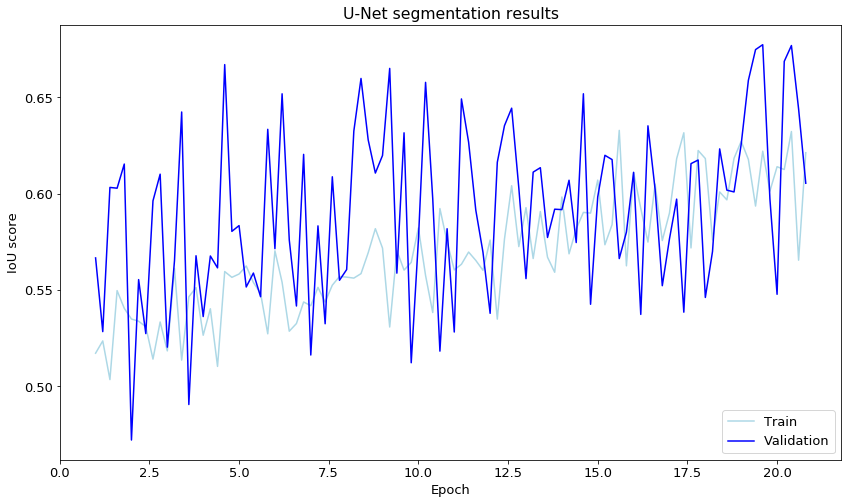

In [257]:
x = np.linspace(1, 41, 201)
plt.plot(x[:len(results['train'])], results['train'], label='Train', color='lightblue')
plt.plot(x[:len(results['val'])], results['val'], label='Validation', color='blue')
plt.title('U-Net segmentation results')
plt.xlabel('Epoch')
plt.ylabel('IoU score')
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams.update({'font.size': 13})
plt.show()

Plot the results to visually compare the prediction and the actual ground truth 

In [248]:
def plot_image_results(img, label):
    # Prepare a single image batch
    batch = nd.reshape(img, (1, 3, img_width, img_height)).as_in_context(ctx)
    
    # Get prediction
    pred = net(batch)
    pred = nd.argmax(pred, axis=1)
    
    plt.subplots(figsize=(16, 8))
    # Plot image
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(mx.nd.transpose(img, (1,2,0)).asnumpy())
    ax1.set_title("Image")

    # Plot prediction
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(pred[0].asnumpy(), cmap='gray')
    ax2.set_title("Predicted")

    # Plot groud truth
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(label[0].asnumpy(),  cmap='gray')
    ax3.set_title("True")
    plt.show()

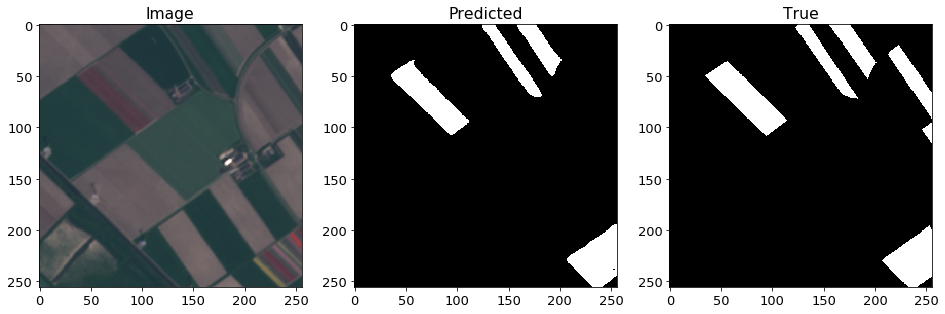

In [249]:
plot_image_results(sample_base, sample_mask)

In [216]:
# Testing purposes
data = nd.reshape(sample_base, (1,3,img_width,img_height)).as_in_context(ctx)
a = net(data)
a = nd.argmax(a, axis=1)